# Minibackend example
This notebook aims to illustrate how `openeo-pg-parser-networkx` can be used together with `openeo-processes-dask` to execute an OpenEO process graph locally.
Note: This capability has also been called the "mini-backend" (see [GH issue with discussion](https://github.com/Open-EO/PSC/issues/16)).

We'll demonstrate this capability through the following steps:
- Load a process graph that represents a computation to be executed on an OpenEO backend and parse it to a traversible Python object using `openeo-pg-parser-networkx`
- Traverse the process graph and maps the nodes to a nested Python function
- Execute that function

Let's go!

## Process graph creation
We'll keep it super simple and use a process graph that: 
1) loads a small part of the boa_sentinel_2 collection
2) computes Enhanced Vegetation Index (EVI) for each pixel
3) multiplies each pixel with a scalar 
4) saves the result as a NetCDF

Specifically, the OpenEO processes necessary to encode this computation are:
1) `load_collection`
2) `reduce_dimension`
    - subprocess: `evi`-processgraph
3) `reduce_dimension`
    - subprocess: `min`
4) `save_result`

In [12]:
from openeo_pg_parser_networkx import OpenEOProcessGraph

EVI_GRAPH_PATH = "../tests/data/graphs/pg-evi-example.json"

parsed_graph = OpenEOProcessGraph.from_file(EVI_GRAPH_PATH)

Deserialised process graph into nested structure


Walking node root-65bb30a5-e976-497e-b25d-27ee3677b3be
Walking node mintime-65bb30a5-e976-497e-b25d-27ee3677b3be
Walking node min-03264498-557c-4c3f-883e-f1db7b2c0280
Walking node evi-65bb30a5-e976-497e-b25d-27ee3677b3be
Walking node m3-954e97cf-1aed-4ceb-a701-9c9d9a728411
Walking node div-954e97cf-1aed-4ceb-a701-9c9d9a728411
Walking node sub-954e97cf-1aed-4ceb-a701-9c9d9a728411
Walking node nir-954e97cf-1aed-4ceb-a701-9c9d9a728411
Walking node red-954e97cf-1aed-4ceb-a701-9c9d9a728411
Walking node sum-954e97cf-1aed-4ceb-a701-9c9d9a728411
Walking node nir-954e97cf-1aed-4ceb-a701-9c9d9a728411
Walking node m1-954e97cf-1aed-4ceb-a701-9c9d9a728411
Walking node red-954e97cf-1aed-4ceb-a701-9c9d9a728411
Walking node m2-954e97cf-1aed-4ceb-a701-9c9d9a728411
Walking node blue-954e97cf-1aed-4ceb-a701-9c9d9a728411
Walking node load_collection-65bb30a5-e976-497e-b25d-27ee3677b3be


In [13]:
parsed_graph

We can see that `OpenEOProcessGraph` has parsed the process graph - let's plot it!


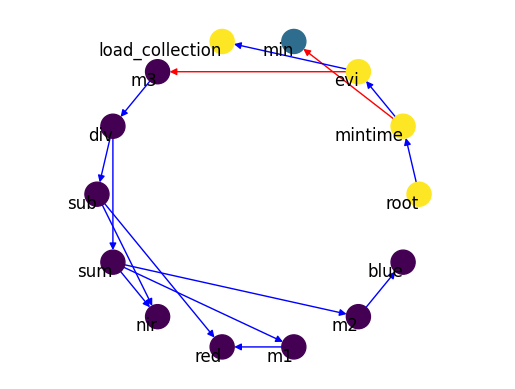

In [14]:
parsed_graph.plot()

The blue edges signify a `ResultReference` edge, where the result of the upstream process needs to be passed down to the downstream process as a parameter. 
E.g. in this process graph the results of `load_collection1` need to be passed on to `evi`. 
The red edges indicate `Callback` edges. These occur when a "parent" process calls upon a "child" process, i.e. to apply a reducer over specific dimension of a datacube. 
In this case the parent process is `reduce_dimension`, which applies the a sub-processgraph to calculate evi for all the pixels.  

## Execute the process graph

To execute a process graph, `OpenEOProcessGraph` needs to know which Python code to call for each of the nodes in the graph. This information is provided by a "process registry", which is basically a dictionary that maps `process_id` to their actual Python implementations as `Callable`s.

 When provided with a ProcessRegistry object (as defined in [openeo-processes-dask](https://github.com/Open-EO/openeo-processes-dask/blob/main/openeo_processes_dask/core.py)), `OpenEOProcessGraph` can translate the process graph into Python code using the `to_callable()` method.

In [ ]:
!pip install openeo_processes_dask

In [16]:
import importlib
import inspect
from openeo_pg_parser_networkx import ProcessRegistry
from openeo_processes_dask.core import process

process_registry = ProcessRegistry(wrap_funcs=[process])

# Import these pre-defined processes from openeo_processes_dask and register them into registry
processes_from_module = [
    func
    for _, func in inspect.getmembers(
        importlib.import_module("openeo_processes_dask.process_implementations"),
        inspect.isfunction,
    )
]

for p in processes_from_module:
    process_registry[p.__name__] = p

# I/O processes aren't generic (yet), therefore have to custom define those. 
def load_collection(id, spatial_extent, temporal_extent, bands = [], properties = {}, **kwargs):
    # No generic implementation available, so need to implement locally!
    pass

def save_result(data, format = 'netcdf', options = None):
    # No generic implementation available, so need to implement locally!
    pass

process_registry["load_collection"] = load_collection
process_registry["save_result"] = save_result

In [17]:
pg_callable = parsed_graph.to_callable(process_registry=process_registry)

In [18]:
pg_callable()

Running process load_collection
kwargs: {'id': <class 'str'>, 'spatial_extent': <class 'openeo_pg_parser_networkx.pg_schema.BoundingBox'>, 'temporal_extent': <class 'openeo_pg_parser_networkx.pg_schema.TemporalInterval'>, 'bands': <class 'list'>}
--------------------------------------------------------------------------------
Running process reduce_dimension
kwargs: {'data': <class 'NoneType'>, 'dimension': <class 'str'>, 'reducer': <class 'functools.partial'>}
--------------------------------------------------------------------------------


AttributeError: 'NoneType' object has no attribute 'dims'